In [27]:
import pandas as pd
import pickle
articles = pd.read_csv("data/articles_metadata.csv")
embeddings = pickle.load(open("data/articles_embeddings.pickle", "rb"))

In [28]:
print(f" Type des embeddings: {type(embeddings)}, taille: {embeddings.shape}")

 Type des embeddings: <class 'numpy.ndarray'>, taille: (364047, 250)


### Visualisation des données d'aricles

In [7]:
articles.head(10)

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
5,5,1,1407413929000,0,196
6,6,1,1409896802000,0,203
7,7,1,1412559620000,0,154
8,8,1,1414351550000,0,209
9,9,1,1412526792000,0,181


### Visualisation des données utilisateurs 

In [8]:
import os
import glob
list_clicks = []
if os.path.exists("data/clicks.parquet"):
    df_clicks = pd.read_parquet("data/clicks.parquet")
else:
    for click_path in glob.glob("data/clicks/clicks_hour_*.csv"):
        list_clicks.append(pd.read_csv(click_path))
    df_clicks= pd.concat(list_clicks)
    df_clicks.to_parquet('data/clicks.parquet')
df_clicks.head(10)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
index,,,,,,,,,,,,
0,93863,1507865792177843,1507865792000,2,96210,1507865832925,4,3,2,1,21,2
1,93863,1507865792177843,1507865792000,2,158094,1507865862925,4,3,2,1,21,2
2,294036,1507865795185844,1507865795000,2,20691,1507865819095,4,3,20,1,9,2
3,294036,1507865795185844,1507865795000,2,96210,1507865849095,4,3,20,1,9,2
4,77136,1507865796257845,1507865796000,2,336245,1507866133178,4,3,2,1,25,2
5,77136,1507865796257845,1507865796000,2,96210,1507866163178,4,3,2,1,25,2
6,16921,1507865798301846,1507865798000,2,159197,1507865858065,4,1,17,1,9,1
7,16921,1507865798301846,1507865798000,2,337441,1507865888065,4,1,17,1,9,1
8,28126,1507865802651847,1507865802000,4,96210,1507865841576,4,1,17,1,25,2


In [30]:
import seaborn as sns
nbr_clicks = df_clicks['user_id'].value_counts()
print(f"Tailles des données: {df_clicks.shape}")
print(f"Nombre d'utilisateurs avec les informations de click {df_clicks['user_id'].unique().shape[0]}")
print(f"Nombre d'articles {articles['article_id'].unique().shape[0]}")
print(f"Nombre d'utilisateurs avec plus de 100 clicks {nbr_clicks[nbr_clicks>100].shape[0]}")

Tailles des données: (2988181, 12)
Nombre d'utilisateurs avec les informations de click 322897
Nombre d'articles 364047
Nombre d'utilisateurs avec plus de 100 clicks 1112


### On calcul le nombre de click par utilisateur par article 

In [31]:
articles_clicks_per_user =df_clicks[['user_id','click_article_id']].assign(rating=1).groupby(['user_id','click_article_id'], as_index=False).agg({'rating': 'sum'})
articles_clicks_per_user[articles_clicks_per_user.rating>20]

,user_id,click_article_id,rating
349853,16280,38823,30
349859,16280,43032,31
349865,16280,68851,33
349924,16280,237071,33
349969,16280,363925,33


## Visulation des données

<Axes: xlabel='user_id', ylabel='click_article_id'>

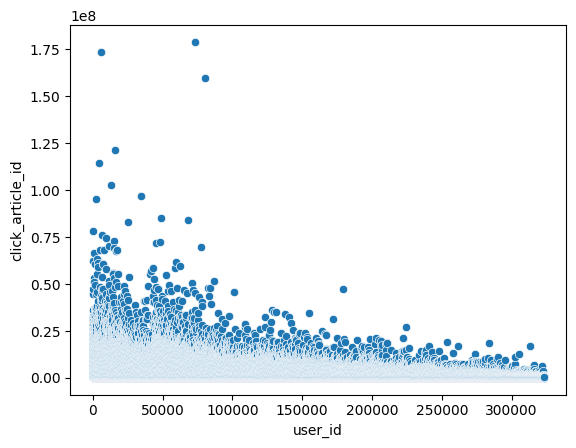

In [41]:
sns.scatterplot(x='user_id', y='click_article_id', data=articles_clicks_per_user.groupby('user_id').agg('sum'))

In [55]:
top_articles = articles_clicks_per_user.groupby('user_id').agg('sum')
top_articles = top_articles.sort_values(by='rating', ascending=False)
top_articles.iloc[:10]

,click_article_id,rating
user_id,,
5890,173631473,1232
73574,179040293,939
15867,121599940,900
80350,159621727,783
15275,73060477,746
2151,95508690,722
4568,114509588,529
12897,102827473,513
11521,70280745,502


## On met en place un filtrage collaboratif avec Surprise

In [16]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
model = SVD()
reader = Reader(rating_scale=(1, 33))
df = Dataset.load_from_df(articles_clicks_per_user, reader)
trainset, testset = train_test_split(df, test_size=0.25)
model.fit(trainset)


### On visualise le top 5 les articles proposer par le système de recommandation hybride (collaboratif et similtude)

In [17]:
from utils import Recommender
recom = Recommender(articles, articles_clicks_per_user, embeddings, model, min_rating=5)

In [18]:
recom.get_top_articles(16280)

,article_id,category_id,created_at_ts,publisher_id,words_count,score
102782,102782,228,1427491122000,0,121,3.172991
68958,68958,136,1505980957000,0,206,3.166202
167623,167623,297,1378962002000,0,211,3.164860
116661,116661,247,1446817054000,0,416,2.932701
43080,43080,71,1505228279000,0,150,2.897448
